# Demo: Convolutional neural networks on the “slash” dataset

*Fraida Fund*

In this demo, we’ll look at an example of a task that is difficult for “classical” machine learning models, and difficult for fully connected neural networks, but easy for convolutional neural networks.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import keras
import numpy as np
import pandas as pd
import scipy

from sklearn.model_selection import train_test_split
from sklearn import ensemble, neighbors, linear_model, svm

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, BatchNormalization, Input, AvgPool2D, MaxPool2D, GlobalAvgPool2D
import tensorflow.keras.backend as K
from keras.utils import plot_model

from ipywidgets import interactive, Layout
import ipywidgets as widgets


## The slash dataset

The “slash” dataset, developed by [Sophie Searcy](https://soph.info/slash-data), is a set of images, each of which includes a “slash” on a background of random noise. The data is divided into two classes according to whether the slash is downward facing or upward facing.

In [ ]:
def gen_example(size=20, label=0):

    max_s_pattern = int(size // 4)
    s_pattern = 4
    pattern = 1- np.eye(s_pattern)
    if label:
        pattern = pattern[:, ::-1]
    ex = np.ones((size,size))
    point_loc = np.random.randint(0, size - s_pattern + 1,
                                  size=(2, ))  # random x,y point
    ex[point_loc[0]:point_loc[0] + s_pattern, point_loc[1]:point_loc[1] +
       s_pattern] = pattern  # set point to
    ex = ex + .5*(np.random.rand(size, size) - .5)
    np.clip(ex,0.,1., out=ex)
    return ex

In [ ]:
examples = []

n_side = 30
n_ex = 500 #number of examples in each class

for i in range(n_ex):
    examples.append(gen_example(size=n_side, label=0))
    examples.append(gen_example(size=n_side, label=1))

y = np.array([0,1]*n_ex)
x = np.stack(examples)

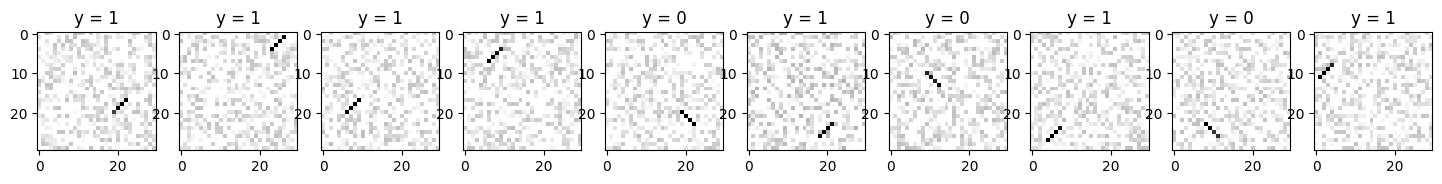

In [ ]:
plt.figure(figsize=(18,4))

n_print = 10 # number of examples to show

ex_indices = np.random.choice(len(y), n_print, replace=False)
for i, index in enumerate(ex_indices):
    plt.subplot(1, n_print, i+1, )
    plt.imshow(x[index,...], cmap='gray')
    plt.title(f"y = {y[index]}")

We’l prepare training and test data in two formats:

-   “flat” for traditional ML models and fully connected neural networks, which don’t care about the spatial arrangement of the features.
-   “image” for convolutional neural networks.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.25)

x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

x_train_img = x_train[...,np.newaxis]
x_test_img = x_test[...,np.newaxis]

In [ ]:
print("Flat data shape:  ", x_train_flat.shape)
print("Image data shape: ", x_train_img.shape)

Flat data shape:   (750, 900)
Image data shape:  (750, 30, 30, 1)


The feature data is in the range 0 to 1:

In [ ]:
x.min(), x.max()

(np.float64(0.0), np.float64(1.0))

## Train logistic regression, random forest, KNN, SVM models

Next, we’ll try to train some classic ML models on this dataset.

In [ ]:
models = {
    "Logistic\n Regression": linear_model.LogisticRegression(),
    "KNN-1": neighbors.KNeighborsClassifier(n_neighbors=1),
    "KNN-3": neighbors.KNeighborsClassifier(n_neighbors=3),
    "Random\n Forest": ensemble.RandomForestClassifier(n_estimators=100),
    "SVM -\n Linear": svm.SVC(kernel="linear"),
    "SVM -\n RBF kernel": svm.SVC(kernel="rbf")
}

In [ ]:
results = []

for model_name in models.keys():
    model = models[model_name]
    model.fit(x_train_flat, y_train)

    train_score = model.score(x_train_flat, y_train)
    test_score = model.score(x_test_flat, y_test)

    results.append({"model": model_name, "train_score": train_score, "test_score": test_score})

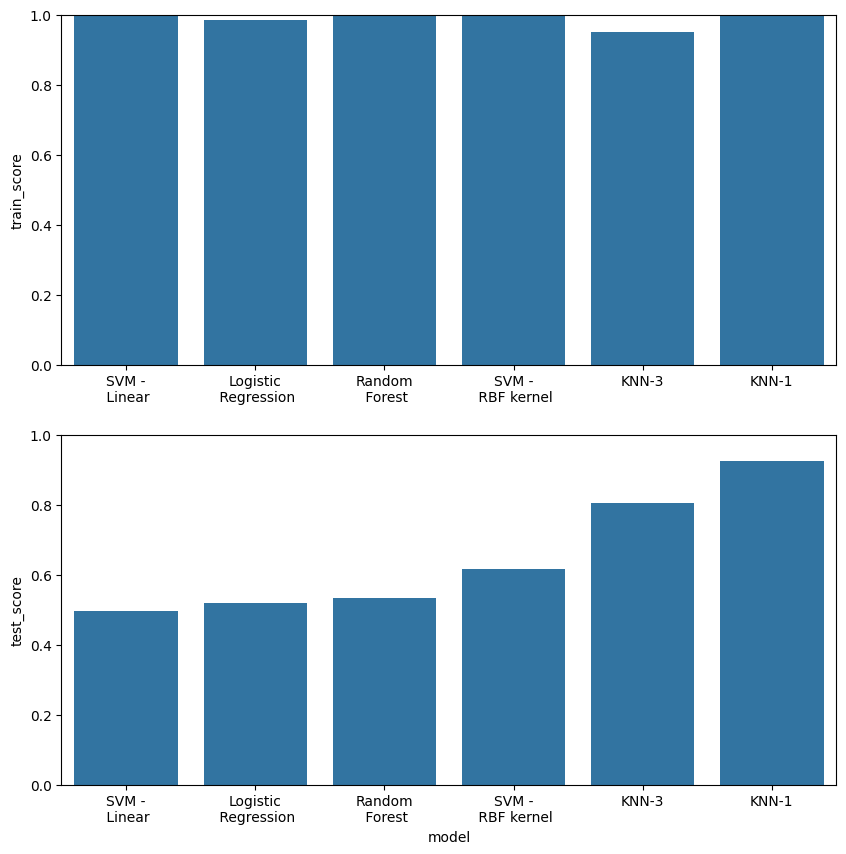

In [ ]:
results_df = pd.DataFrame(results)

plt.figure(figsize =(10,10));

plt.subplot(2,1,1)
sns.barplot(x=results_df.sort_values('test_score')['model'], y=results_df.sort_values('test_score')['train_score']);
plt.ylim(0,1);
plt.xlabel("")

plt.subplot(2,1,2)
sns.barplot(x=results_df.sort_values('test_score')['model'], y=results_df.sort_values('test_score')['test_score']);
plt.ylim(0,1);

Are these the results we expected? Why or why not?

Do *any* of these models do a good job of learning whether a slash is forward-facing or backward-facing?

## Train a fully connected neural network

In [ ]:
nin = x_train_flat.shape[1]
nh1 = 64
nh2 = 64
nh3 = 64
nout = 1
model_fc = Sequential()
model_fc.add(Input(shape=(nin,)))
model_fc.add(Dense(units=nh1, activation='relu', name='hidden1'))
model_fc.add(Dense(units=nh2, activation='relu', name='hidden2'))
model_fc.add(Dense(units=nh3, activation='relu', name='hidden3'))
model_fc.add(Dense(units=nout, activation='sigmoid', name='output'))

model_fc.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_fc.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 64)             │        57,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,049 (258.00 KB)

 Trainable params: 66,049 (258.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist = model_fc.fit(x_train_flat, y_train, epochs=100,
     validation_split=0.25,  callbacks=[
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=2, verbose=1),
        keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=1)
    ])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5566 - loss: 0.7084 - val_accuracy: 0.5426 - val_loss: 0.6948 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4396 - loss: 0.7094 - val_accuracy: 0.4574 - val_loss: 0.7114 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5304 - loss: 0.6996 - val_accuracy: 0.5426 - val_loss: 0.6935 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4532 - loss: 0.7064 - val_accuracy: 0.4309 - val_loss: 0.6936 - learning_rate: 0.0010
Epoch 5/100
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5652 - loss: 0.6945  
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5423 - loss: 0.6954 - val_accuracy: 0.4468 - val_loss: 0.6941 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5264 - loss: 0.6935 - val_

In [ ]:
train_score = model_fc.evaluate(x_train_flat, y_train)[1]
test_score = model_fc.evaluate(x_test_flat, y_test)[1]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4851 - loss: 0.7115 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4988 - loss: 0.7066 


In [ ]:
results.append({"model": 'FC Neural Net', "train_score": train_score, "test_score": test_score})

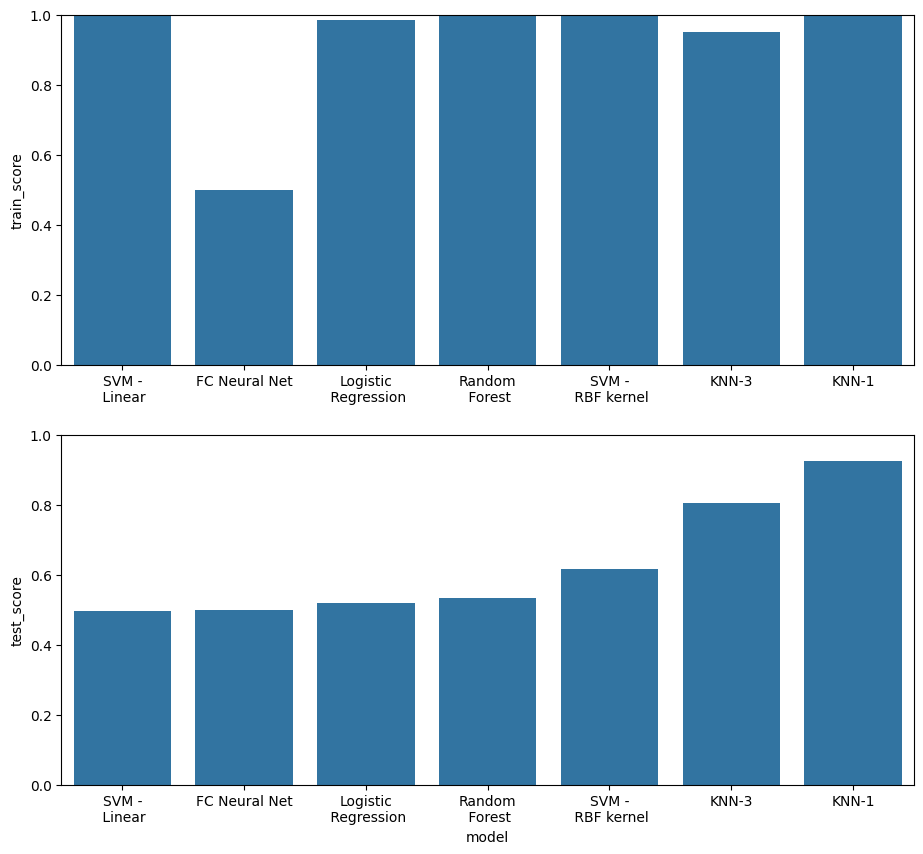

In [ ]:
results_df = pd.DataFrame(results)

plt.figure(figsize =(11,10));

plt.subplot(2,1,1)
sns.barplot(x=results_df.sort_values('test_score')['model'], y=results_df.sort_values('test_score')['train_score']);
plt.ylim(0,1);
plt.xlabel("")

plt.subplot(2,1,2)
sns.barplot(x=results_df.sort_values('test_score')['model'], y=results_df.sort_values('test_score')['test_score']);
plt.ylim(0,1);

## Train a convolutional neural network

In [ ]:
filters = 10
model_conv = Sequential()
model_conv.add(Input(shape=x_train_img.shape[1:]))
model_conv.add(Conv2D(filters, kernel_size=3, padding="same", activation="relu", use_bias=False ))
model_conv.add(MaxPool2D(pool_size=(2, 2)))
model_conv.add(BatchNormalization())
model_conv.add(Conv2D(filters, kernel_size=3, padding="same", activation="relu", use_bias=False ))
model_conv.add(GlobalAvgPool2D())
model_conv.add(Dense(1, activation="sigmoid"))

model_conv.summary()

model_conv.compile("adam", loss="binary_crossentropy", metrics=["accuracy"])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 10)     │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 15, 15, 10)     │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 15, 15, 10)     │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 10)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,041 (4.07 KB)

 Trainable params: 1,021 (3.99 KB)

 Non-trainable params: 20 (80.00 B)

In [ ]:
hist = model_conv.fit(x_train_img, y_train, epochs=100,
     validation_split=0.25,  callbacks=[
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=2, verbose=1),
        keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=1)
    ])

train_score = model_conv.evaluate(x_train_img, y_train)[1]
test_score = model_conv.evaluate(x_test_img, y_test)[1]

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5389 - loss: 0.6898 - val_accuracy: 0.4574 - val_loss: 0.6936 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5847 - loss: 0.6841 - val_accuracy: 0.5426 - val_loss: 0.6915 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7745 - loss: 0.6751 - val_accuracy: 0.5426 - val_loss: 0.6895 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8028 - loss: 0.6603 - val_accuracy: 0.5426 - val_loss: 0.6880 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8088 - loss: 0.6353 - val_accuracy: 0.5426 - val_loss: 0.6849 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9346 - loss: 0.5982 - val_accuracy: 0.5426 - val_loss: 0.6786 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9941 - loss: 0.5390 - 

In [ ]:
results.append({"model": 'ConvNet', "train_score": train_score, "test_score": test_score})

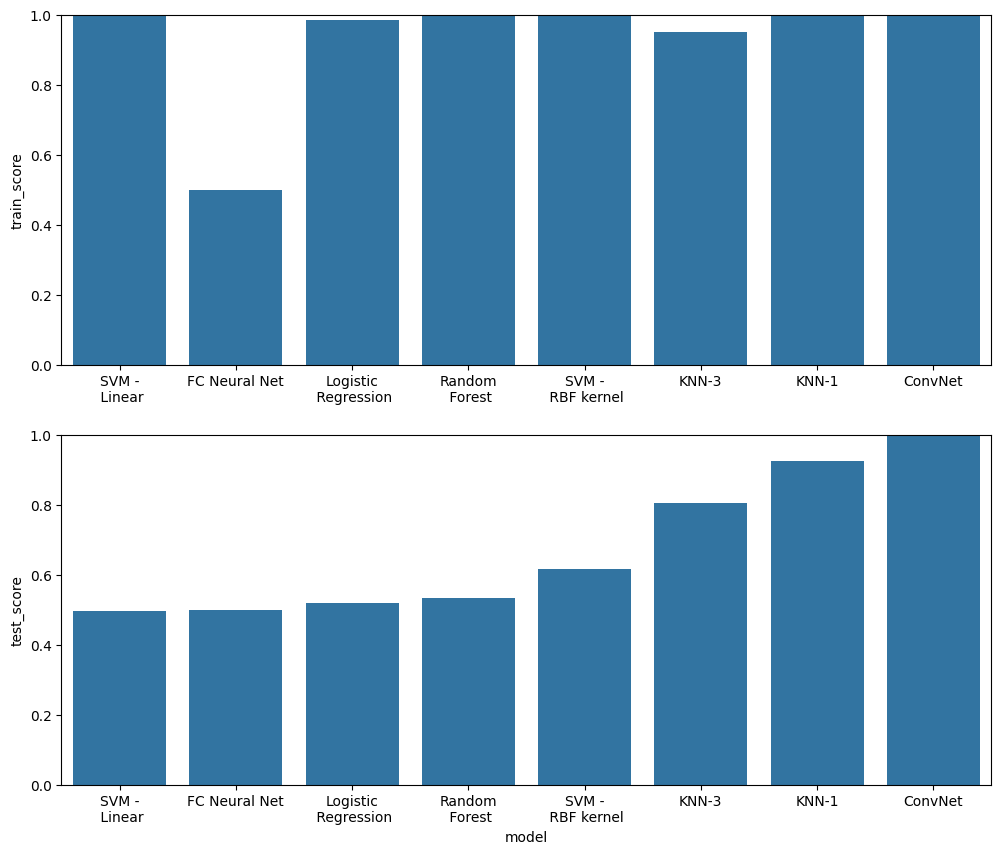

In [ ]:
results_df = pd.DataFrame(results)

plt.figure(figsize =(12,10));

plt.subplot(2,1,1)
sns.barplot(x=results_df.sort_values('test_score')['model'], y=results_df.sort_values('test_score')['train_score']);
plt.ylim(0,1);
plt.xlabel("")

plt.subplot(2,1,2)
sns.barplot(x=results_df.sort_values('test_score')['model'], y=results_df.sort_values('test_score')['test_score']);
plt.ylim(0,1);

## Using the same model on different slashes

Not only did our convolutional network learn forward and backward slashes - it can even generalize to slightly different forward and backward slashes.

Let’s generate data with heavier background noise, and longer slashes:

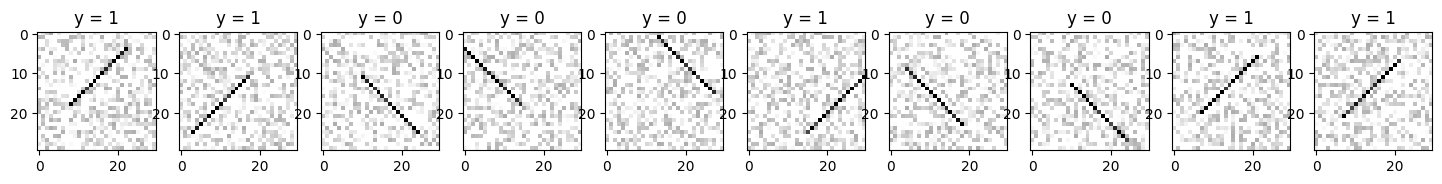

In [ ]:
noise_scale = 0.65
s_pattern = 15
def gen_example_different(size=20, label=0):

    max_s_pattern = int(size // 4)
    pattern = 1- np.eye(s_pattern)
    if label:
        pattern = pattern[:, ::-1]
    ex = np.ones((size,size))
    point_loc = np.random.randint(0, size - s_pattern + 1,
                                  size=(2, ))  # random x,y point
    ex[point_loc[0]:point_loc[0] + s_pattern, point_loc[1]:point_loc[1] +
       s_pattern] = pattern  # set point to
    ex = ex + noise_scale*(np.random.rand(size, size) - .5)
    np.clip(ex,0.,1., out=ex)
    return ex

examples = []

n_side = 30
n_ex = 50 #number of examples in each class

for i in range(n_ex):
    examples.append(gen_example_different(size=n_side, label=0))
    examples.append(gen_example_different(size=n_side, label=1))

y_new = np.array([0,1]*n_ex)
x_new = np.stack(examples)

plt.figure(figsize=(18,4))

n_print = 10 # number of examples to show

ex_indices = np.random.choice(len(y_new), n_print, replace=False)
for i, index in enumerate(ex_indices):
    plt.subplot(1, n_print, i+1, )
    plt.imshow(x_new[index,...], cmap='gray')
    plt.title(f"y = {y_new[index]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


<ipython-input-21-bc8c19b31f1f>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title("yhat =  %0.2f" % model_conv.predict(x_new[index].reshape((1,30,30,1))))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


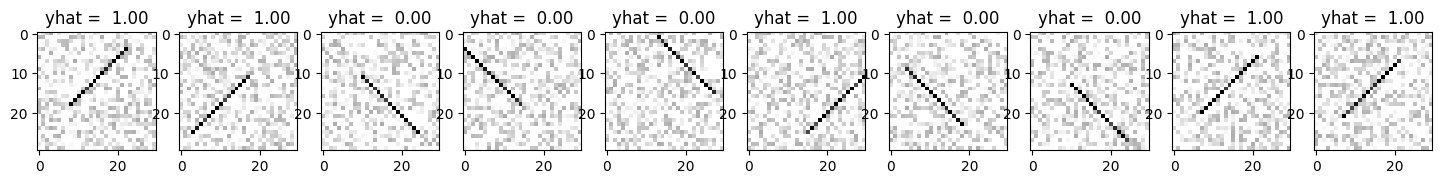

In [ ]:
plt.figure(figsize=(18,4))

for i, index in enumerate(ex_indices):
    plt.subplot(1, n_print, i+1, )
    plt.imshow(x_new[index,...], cmap='gray')
    plt.title("yhat =  %0.2f" % model_conv.predict(x_new[index].reshape((1,30,30,1))))

In [ ]:
new_test_score = model_conv.evaluate(x_new[...,np.newaxis], y_new)[1]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 3.1021e-10


What about forward and backward slashes at different angles?

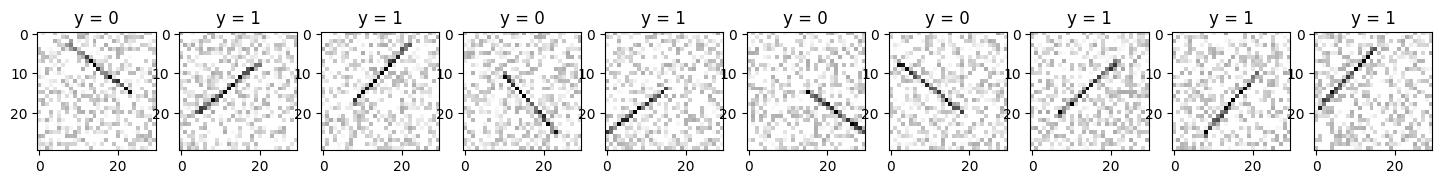

In [ ]:
max_rot = 10
def gen_example_rotated(size=20, label=0):

    max_s_pattern = int(size // 4)
    s_pattern = 15
    pattern = 1- np.eye(s_pattern)
    if label:
        pattern = pattern[:, ::-1]
    ex = np.ones((size,size))
    point_loc = np.random.randint(0, size - s_pattern + 1,   size=(2, ))
    ex[point_loc[0]:point_loc[0] + s_pattern, point_loc[1]:point_loc[1] + s_pattern] = pattern
    rot_angle = np.random.uniform(-max_rot, max_rot)
    ex = scipy.ndimage.rotate(ex, angle=rot_angle, cval=1, reshape = False)
    ex = ex + noise_scale*(np.random.rand(size, size) - .5)

    np.clip(ex,0.,1., out=ex)
    return ex

examples = []

n_side = 30
n_ex = 50 #number of examples in each class

for i in range(n_ex):
    examples.append(gen_example_rotated(size=n_side, label=0))
    examples.append(gen_example_rotated(size=n_side, label=1))

y_new = np.array([0,1]*n_ex)
x_new = np.stack(examples)

plt.figure(figsize=(18,4))

n_print = 10 # number of examples to show

ex_indices = np.random.choice(len(y_new), n_print, replace=False)
for i, index in enumerate(ex_indices):
    plt.subplot(1, n_print, i+1, )
    plt.imshow(x_new[index,...], cmap='gray')
    plt.title(f"y = {y_new[index]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

<ipython-input-24-bc8c19b31f1f>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title("yhat =  %0.2f" % model_conv.predict(x_new[index].reshape((1,30,30,1))))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


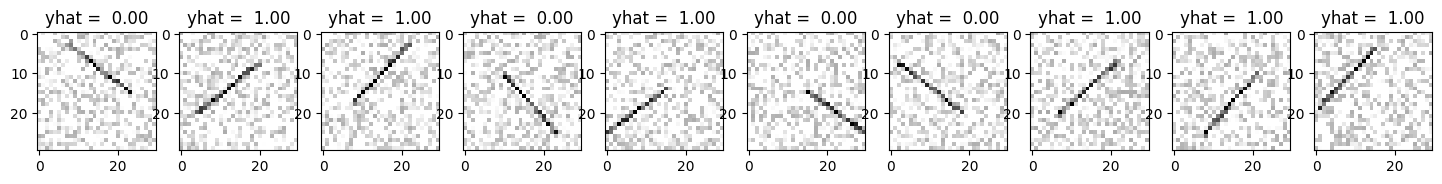

In [ ]:
plt.figure(figsize=(18,4))

for i, index in enumerate(ex_indices):
    plt.subplot(1, n_print, i+1, )
    plt.imshow(x_new[index,...], cmap='gray')
    plt.title("yhat =  %0.2f" % model_conv.predict(x_new[index].reshape((1,30,30,1))))

In [ ]:
new_test_score = model_conv.evaluate(x_new[...,np.newaxis], y_new)[1]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 5.3243e-07


## Visualizing what the network learns

In [ ]:
def plot_layer(test_idx, layer_idx):
    # Create a new model that outputs the target layer instead of using K.function()
    layer_model = tf.keras.Model(inputs=model_conv.inputs,
                               outputs=model_conv.layers[layer_idx].output)

    #convout1_f = K.function(model_conv.inputs, [model_conv.layers[layer_idx].output])

    # Get the layer output using this model
    layer_output = layer_model(tf.convert_to_tensor(x[test_idx].reshape((1,30,30,1))))
    convolutions = np.squeeze(layer_output.numpy())

    #convolutions = np.squeeze(convout1_f(x[test_idx].reshape((1,30,30,1))))

    if (len(convolutions.shape)) > 1:
        m = convolutions.shape[2]
        n = int(np.ceil(np.sqrt(m)))

        # Visualization of each filter of the layer
        fig = plt.figure(figsize=(15,12))
        print(model_conv.layers[layer_idx].name)
        for i in range(m):
            ax = fig.add_subplot(n,n,i+1)
            ax.imshow(convolutions[:,:,i], cmap='gray')
            ax.set_title(i)
    else:
        print(model_conv.layers[layer_idx].name)
        plt.imshow(convolutions.reshape(1, convolutions.shape[0]), cmap='gray')
        plt.yticks([])
        plt.xticks(range(convolutions.shape[0]))
    plt.show()


style = {'description_width': 'initial'}
layout = Layout(width="800px")
test_idx = widgets.IntSlider(min=0, max=len(x)-1, value=0, style=style, layout=layout)
layer_idx = widgets.IntSlider(min=0, max=len(model_conv.layers)-2, value=0, style=style, layout=layout)


interactive(plot_layer, test_idx=test_idx, layer_idx=layer_idx)

interactive(children=(IntSlider(value=0, description='test_idx', layout=Layout(width='800px'), max=999, style=…